# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [88]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [89]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [70]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

In [14]:
a = np.array([[1,2], [3, 4], [5, 6]])

# An example of integer array indexing.
# The returned array will have shape (3,) and
print(a[[0, 1, 2], [0, 1, 0]])  

[1 4 5]


In [16]:
print(a[[0, 0], [1, 1]])  # Prints "[2 2]"

[2 2]


In [19]:
a[[0, 0], [1, 1]]

array([2, 2])

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [118]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

In [124]:
test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [133]:
np.array([[1], [1], [1]]).reshape((test.shape[0],))

array([1, 1, 1])

In [126]:
test[]

array([[[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]]])

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [135]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [137]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [138]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [151]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 26252.208314
Epoch 1, loss: 27868.668774
Epoch 2, loss: 25708.279207
Epoch 3, loss: 26860.866901
Epoch 4, loss: 26496.650813
Epoch 5, loss: 25138.120639
Epoch 6, loss: 27015.038948
Epoch 7, loss: 27276.311764
Epoch 8, loss: 27076.233522
Epoch 9, loss: 26956.724706


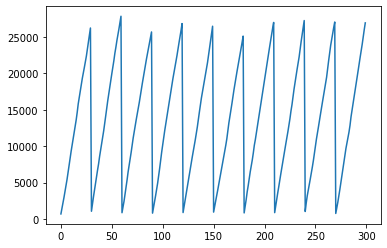

In [152]:
# let's look at the loss history!
plt.plot(loss_history)

In [160]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=5000, learning_rate=1e-5, batch_size=300, reg=1e-4)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.248
Epoch 0, loss: 18746.502386
Epoch 1, loss: 18745.790804
Epoch 2, loss: 18745.658892
Epoch 3, loss: 18745.519036
Epoch 4, loss: 18744.861793
Epoch 5, loss: 18744.583473
Epoch 6, loss: 18744.535772
Epoch 7, loss: 18743.864033
Epoch 8, loss: 18743.582860
Epoch 9, loss: 18743.345899
Epoch 10, loss: 18743.373999
Epoch 11, loss: 18742.704632
Epoch 12, loss: 18741.971732
Epoch 13, loss: 18741.594418
Epoch 14, loss: 18741.233436
Epoch 15, loss: 18741.737600
Epoch 16, loss: 18741.188958
Epoch 17, loss: 18740.586307
Epoch 18, loss: 18740.286186
Epoch 19, loss: 18740.028487
Epoch 20, loss: 18739.391020
Epoch 21, loss: 18739.288826
Epoch 22, loss: 18738.613996
Epoch 23, loss: 18738.421891
Epoch 24, loss: 18737.519651
Epoch 25, loss: 18737.500858
Epoch 26, loss: 18737.072011
Epoch 27, loss: 18737.001189
Epoch 28, loss: 18736.949449
Epoch 29, loss: 18736.248608
Epoch 30, loss: 18736.040803
Epoch 31, loss: 18735.781858
Epoch 32, loss: 18735.277154
Epoch 33, loss: 18734.947713
Epoch 3

Epoch 278, loss: 18657.168419
Epoch 279, loss: 18656.909981
Epoch 280, loss: 18656.414848
Epoch 281, loss: 18656.458614
Epoch 282, loss: 18656.040256
Epoch 283, loss: 18655.878415
Epoch 284, loss: 18655.627415
Epoch 285, loss: 18655.996097
Epoch 286, loss: 18655.013909
Epoch 287, loss: 18654.885868
Epoch 288, loss: 18654.523808
Epoch 289, loss: 18654.246253
Epoch 290, loss: 18653.739121
Epoch 291, loss: 18653.731981
Epoch 292, loss: 18652.369098
Epoch 293, loss: 18652.576594
Epoch 294, loss: 18652.738679
Epoch 295, loss: 18652.353236
Epoch 296, loss: 18652.081085
Epoch 297, loss: 18651.857098
Epoch 298, loss: 18651.385669
Epoch 299, loss: 18651.213678
Epoch 300, loss: 18651.272744
Epoch 301, loss: 18650.891278
Epoch 302, loss: 18650.116168
Epoch 303, loss: 18650.052147
Epoch 304, loss: 18649.647837
Epoch 305, loss: 18649.219290
Epoch 306, loss: 18649.176593
Epoch 307, loss: 18648.869802
Epoch 308, loss: 18648.757959
Epoch 309, loss: 18648.981543
Epoch 310, loss: 18648.093234
Epoch 311,

KeyboardInterrupt: 

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [158]:
num_epochs = 1000
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None


for lr in learning_rates:
    for reg_str in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg_str)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
        print(lr, reg_str, accuracy)
            

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 25306.660168
Epoch 1, loss: 27569.529045
Epoch 2, loss: 26964.402296
Epoch 3, loss: 26048.273622
Epoch 4, loss: 25141.151363
Epoch 5, loss: 25825.483048
Epoch 6, loss: 24302.876825
Epoch 7, loss: 25796.736375
Epoch 8, loss: 24161.044151
Epoch 9, loss: 24770.291996
Epoch 10, loss: 25693.325390
Epoch 11, loss: 24999.597484
Epoch 12, loss: 25483.329420
Epoch 13, loss: 25608.645922
Epoch 14, loss: 24331.394676
Epoch 15, loss: 24416.020131
Epoch 16, loss: 26280.515603
Epoch 17, loss: 24606.731927
Epoch 18, loss: 24453.715138
Epoch 19, loss: 24262.957493
Epoch 20, loss: 24002.828169
Epoch 21, loss: 23241.954912
Epoch 22, loss: 24948.991284
Epoch 23, loss: 24972.532309
Epoch 24, loss: 24816.022598
Epoch 25, loss: 23955.300295
Epoch 26, loss: 23368.090623
Epoch 27, loss: 24847.009616
Epoch 28, loss: 22747.249583
Epoch 29, loss: 23878.358229
Epoch 30, loss: 22632.753323
Epoch 31, loss: 24338.773425
Epoch 32, loss: 23258.378294
Epoch 33, loss: 25678.936307
Epoch 34, loss: 24406.96

Epoch 277, loss: 22670.933227
Epoch 278, loss: 21462.952971
Epoch 279, loss: 22407.020808
Epoch 280, loss: 21869.748592
Epoch 281, loss: 21281.275677
Epoch 282, loss: 22178.074979
Epoch 283, loss: 21231.910972
Epoch 284, loss: 22793.522140
Epoch 285, loss: 21504.320704
Epoch 286, loss: 21730.945307
Epoch 287, loss: 21978.634487
Epoch 288, loss: 19936.263589
Epoch 289, loss: 23160.803173
Epoch 290, loss: 20758.414156
Epoch 291, loss: 21973.344512
Epoch 292, loss: 21000.387878
Epoch 293, loss: 22599.218675
Epoch 294, loss: 21791.519153
Epoch 295, loss: 21220.730662
Epoch 296, loss: 21778.079368
Epoch 297, loss: 21467.241021
Epoch 298, loss: 22501.002537
Epoch 299, loss: 21049.689827
Epoch 300, loss: 21888.630313
Epoch 301, loss: 20443.272415
Epoch 302, loss: 22146.603576
Epoch 303, loss: 20936.816268
Epoch 304, loss: 21882.725813
Epoch 305, loss: 22602.677494
Epoch 306, loss: 20333.706334
Epoch 307, loss: 22000.000801
Epoch 308, loss: 21424.076400
Epoch 309, loss: 21747.098158
Epoch 310,

Epoch 552, loss: 20843.087348
Epoch 553, loss: 19884.279032
Epoch 554, loss: 21142.318790
Epoch 555, loss: 20734.570424
Epoch 556, loss: 20953.797332
Epoch 557, loss: 20302.619102
Epoch 558, loss: 21451.945201
Epoch 559, loss: 19880.117095
Epoch 560, loss: 21870.181602
Epoch 561, loss: 21331.623402
Epoch 562, loss: 21086.105279
Epoch 563, loss: 20060.725876
Epoch 564, loss: 19627.733109
Epoch 565, loss: 21533.933805
Epoch 566, loss: 21240.973838
Epoch 567, loss: 21194.203170
Epoch 568, loss: 20456.019693
Epoch 569, loss: 20889.275768
Epoch 570, loss: 21421.329384
Epoch 571, loss: 20190.509133
Epoch 572, loss: 20131.040762
Epoch 573, loss: 19759.833212
Epoch 574, loss: 20878.019893
Epoch 575, loss: 20386.023133
Epoch 576, loss: 21568.725776
Epoch 577, loss: 20894.502860
Epoch 578, loss: 20109.539253
Epoch 579, loss: 19247.057315
Epoch 580, loss: 21622.527036
Epoch 581, loss: 21345.520956
Epoch 582, loss: 22255.244991
Epoch 583, loss: 20079.144787
Epoch 584, loss: 20074.456442
Epoch 585,

Epoch 828, loss: 20186.247169
Epoch 829, loss: 21268.538620
Epoch 830, loss: 19190.930108
Epoch 831, loss: 20051.526525
Epoch 832, loss: 21350.181562
Epoch 833, loss: 20432.699745
Epoch 834, loss: 20631.433828
Epoch 835, loss: 20252.036604
Epoch 836, loss: 20188.314613
Epoch 837, loss: 21078.408681
Epoch 838, loss: 20361.260767
Epoch 839, loss: 20561.418183
Epoch 840, loss: 19960.012073
Epoch 841, loss: 19058.461675
Epoch 842, loss: 20839.306084
Epoch 843, loss: 20631.804454
Epoch 844, loss: 19770.610773
Epoch 845, loss: 20036.365947
Epoch 846, loss: 19881.830888
Epoch 847, loss: 19922.019066
Epoch 848, loss: 20178.089884
Epoch 849, loss: 19987.977468
Epoch 850, loss: 20442.440682
Epoch 851, loss: 20992.277102
Epoch 852, loss: 19424.422488
Epoch 853, loss: 19818.949214
Epoch 854, loss: 20000.759761
Epoch 855, loss: 21138.494443
Epoch 856, loss: 20865.528199
Epoch 857, loss: 20150.918324
Epoch 858, loss: 20732.583583
Epoch 859, loss: 21464.538148
Epoch 860, loss: 20781.267947
Epoch 861,

Epoch 106, loss: 24317.648807
Epoch 107, loss: 23039.845881
Epoch 108, loss: 22775.990514
Epoch 109, loss: 23071.648877
Epoch 110, loss: 22125.614315
Epoch 111, loss: 21831.920438
Epoch 112, loss: 23361.100263
Epoch 113, loss: 23702.860361
Epoch 114, loss: 22859.035601
Epoch 115, loss: 22951.337558
Epoch 116, loss: 23569.862212
Epoch 117, loss: 22349.046905
Epoch 118, loss: 23416.647939
Epoch 119, loss: 22920.024511
Epoch 120, loss: 21611.869660
Epoch 121, loss: 23837.203368
Epoch 122, loss: 23098.415188
Epoch 123, loss: 22743.066742
Epoch 124, loss: 22635.041506
Epoch 125, loss: 23215.872623
Epoch 126, loss: 23020.831077
Epoch 127, loss: 23208.129243
Epoch 128, loss: 22443.331529
Epoch 129, loss: 22691.544897
Epoch 130, loss: 21731.989442
Epoch 131, loss: 22747.122405
Epoch 132, loss: 22566.893765
Epoch 133, loss: 21991.184606
Epoch 134, loss: 22482.407729
Epoch 135, loss: 22402.009598
Epoch 136, loss: 22198.319818
Epoch 137, loss: 22961.382257
Epoch 138, loss: 21435.295807
Epoch 139,

Epoch 380, loss: 21484.626764
Epoch 381, loss: 22479.832805
Epoch 382, loss: 21420.658015
Epoch 383, loss: 20202.891182
Epoch 384, loss: 22019.611417
Epoch 385, loss: 21484.883712
Epoch 386, loss: 21270.224642
Epoch 387, loss: 21092.518805
Epoch 388, loss: 22190.597370
Epoch 389, loss: 21839.236553
Epoch 390, loss: 21294.602088
Epoch 391, loss: 21910.969730
Epoch 392, loss: 20261.360168
Epoch 393, loss: 21500.955953
Epoch 394, loss: 21656.617381
Epoch 395, loss: 20658.208098
Epoch 396, loss: 22581.554893
Epoch 397, loss: 21416.752122
Epoch 398, loss: 20078.209113
Epoch 399, loss: 20528.205854
Epoch 400, loss: 21764.213805
Epoch 401, loss: 20388.028798
Epoch 402, loss: 21220.157085
Epoch 403, loss: 22584.547914
Epoch 404, loss: 21299.066911
Epoch 405, loss: 21684.192745
Epoch 406, loss: 21192.882660
Epoch 407, loss: 19856.286906
Epoch 408, loss: 22383.131875
Epoch 409, loss: 19855.812705
Epoch 410, loss: 21525.504251
Epoch 411, loss: 21473.254703
Epoch 412, loss: 21734.314241
Epoch 413,

Epoch 655, loss: 20141.596437
Epoch 656, loss: 21363.334881
Epoch 657, loss: 20141.816216
Epoch 658, loss: 21210.378371
Epoch 659, loss: 21014.832962
Epoch 660, loss: 20040.365601
Epoch 661, loss: 20555.937049
Epoch 662, loss: 21229.909207
Epoch 663, loss: 19543.638717
Epoch 664, loss: 20202.081448
Epoch 665, loss: 19606.012779
Epoch 666, loss: 20493.563999
Epoch 667, loss: 22053.086620
Epoch 668, loss: 19854.306589
Epoch 669, loss: 21386.801550
Epoch 670, loss: 19897.152901
Epoch 671, loss: 20905.012155
Epoch 672, loss: 20908.371759
Epoch 673, loss: 19164.252104
Epoch 674, loss: 20536.670818
Epoch 675, loss: 20078.003190
Epoch 676, loss: 21475.862595
Epoch 677, loss: 19432.711619
Epoch 678, loss: 19711.460512
Epoch 679, loss: 21856.153170
Epoch 680, loss: 20283.961763
Epoch 681, loss: 21921.320201
Epoch 682, loss: 20147.281255
Epoch 683, loss: 21055.537863
Epoch 684, loss: 20664.559049
Epoch 685, loss: 20795.452794
Epoch 686, loss: 19793.126148
Epoch 687, loss: 20241.205543
Epoch 688,

Epoch 930, loss: 19965.648505
Epoch 931, loss: 20323.097176
Epoch 932, loss: 20074.097415
Epoch 933, loss: 20654.583393
Epoch 934, loss: 20075.929835
Epoch 935, loss: 19369.449709
Epoch 936, loss: 20093.803441
Epoch 937, loss: 20052.280614
Epoch 938, loss: 19419.395226
Epoch 939, loss: 20725.232897
Epoch 940, loss: 20410.194476
Epoch 941, loss: 19551.964829
Epoch 942, loss: 20255.688015
Epoch 943, loss: 20181.879799
Epoch 944, loss: 19783.423907
Epoch 945, loss: 19077.718136
Epoch 946, loss: 20695.728871
Epoch 947, loss: 18831.447327
Epoch 948, loss: 20884.889036
Epoch 949, loss: 19787.150878
Epoch 950, loss: 19459.556416
Epoch 951, loss: 20153.494214
Epoch 952, loss: 21373.870649
Epoch 953, loss: 20005.342243
Epoch 954, loss: 19011.541659
Epoch 955, loss: 20161.452779
Epoch 956, loss: 20482.310776
Epoch 957, loss: 20239.581363
Epoch 958, loss: 20126.018312
Epoch 959, loss: 19339.884229
Epoch 960, loss: 20820.847875
Epoch 961, loss: 19815.012842
Epoch 962, loss: 20045.532258
Epoch 963,

Epoch 208, loss: 21796.819879
Epoch 209, loss: 21883.653125
Epoch 210, loss: 22282.824850
Epoch 211, loss: 22494.182019
Epoch 212, loss: 21547.504568
Epoch 213, loss: 22776.641865
Epoch 214, loss: 21741.878355
Epoch 215, loss: 22588.079792
Epoch 216, loss: 21834.669902
Epoch 217, loss: 22225.009895
Epoch 218, loss: 22187.370438
Epoch 219, loss: 22028.251163
Epoch 220, loss: 22168.168920
Epoch 221, loss: 22739.584759
Epoch 222, loss: 22006.030811
Epoch 223, loss: 23111.343809
Epoch 224, loss: 22527.999416
Epoch 225, loss: 22094.799586
Epoch 226, loss: 21860.975406
Epoch 227, loss: 21710.382296
Epoch 228, loss: 21726.820183
Epoch 229, loss: 21793.544733
Epoch 230, loss: 21689.718600
Epoch 231, loss: 21608.608422
Epoch 232, loss: 21647.539007
Epoch 233, loss: 21599.589955
Epoch 234, loss: 21749.310206
Epoch 235, loss: 22927.895548
Epoch 236, loss: 21916.860301
Epoch 237, loss: 21241.184722
Epoch 238, loss: 22553.614470
Epoch 239, loss: 21846.047731
Epoch 240, loss: 21287.689550
Epoch 241,

Epoch 482, loss: 20216.259279
Epoch 483, loss: 21722.043946
Epoch 484, loss: 21444.000604
Epoch 485, loss: 19696.131349
Epoch 486, loss: 22607.278625
Epoch 487, loss: 21646.368118
Epoch 488, loss: 21373.034873
Epoch 489, loss: 21006.087383
Epoch 490, loss: 21453.895239
Epoch 491, loss: 20842.764443
Epoch 492, loss: 20571.663819
Epoch 493, loss: 21316.338363
Epoch 494, loss: 21701.534009
Epoch 495, loss: 21836.846376
Epoch 496, loss: 20621.960381
Epoch 497, loss: 20888.904749
Epoch 498, loss: 21518.138686
Epoch 499, loss: 21006.266800
Epoch 500, loss: 20793.748754
Epoch 501, loss: 20633.462169
Epoch 502, loss: 20569.517840
Epoch 503, loss: 21518.148168
Epoch 504, loss: 20303.681123
Epoch 505, loss: 21076.632585
Epoch 506, loss: 20195.848712
Epoch 507, loss: 21278.382174
Epoch 508, loss: 21130.010780
Epoch 509, loss: 20120.311243
Epoch 510, loss: 21466.229104
Epoch 511, loss: 21252.993755
Epoch 512, loss: 21699.144884
Epoch 513, loss: 21001.361960
Epoch 514, loss: 21151.858489
Epoch 515,

Epoch 757, loss: 21077.420416
Epoch 758, loss: 19845.715823
Epoch 759, loss: 19508.027302
Epoch 760, loss: 21371.856580
Epoch 761, loss: 21120.761110
Epoch 762, loss: 20365.386837
Epoch 763, loss: 20986.453073
Epoch 764, loss: 19985.256324
Epoch 765, loss: 21757.818645
Epoch 766, loss: 20943.978005
Epoch 767, loss: 20725.024683
Epoch 768, loss: 19919.194453
Epoch 769, loss: 20169.215299
Epoch 770, loss: 20561.897158
Epoch 771, loss: 21504.231351
Epoch 772, loss: 19519.914441
Epoch 773, loss: 20339.477423
Epoch 774, loss: 20828.332882
Epoch 775, loss: 19883.897224
Epoch 776, loss: 19289.758208
Epoch 777, loss: 21416.572443
Epoch 778, loss: 20114.645917
Epoch 779, loss: 19861.740945
Epoch 780, loss: 21574.072629
Epoch 781, loss: 20534.180144
Epoch 782, loss: 21104.786015
Epoch 783, loss: 20307.778632
Epoch 784, loss: 20651.391410
Epoch 785, loss: 21881.996283
Epoch 786, loss: 19011.845626
Epoch 787, loss: 21031.941719
Epoch 788, loss: 20314.996190
Epoch 789, loss: 19384.976360
Epoch 790,

Epoch 32, loss: 19179.690548
Epoch 33, loss: 19168.082206
Epoch 34, loss: 19157.470105
Epoch 35, loss: 19150.200153
Epoch 36, loss: 19134.617557
Epoch 37, loss: 19123.763029
Epoch 38, loss: 19118.231608
Epoch 39, loss: 19113.089613
Epoch 40, loss: 19100.948255
Epoch 41, loss: 19089.049559
Epoch 42, loss: 19079.301376
Epoch 43, loss: 19078.988453
Epoch 44, loss: 19068.997624
Epoch 45, loss: 19056.791459
Epoch 46, loss: 19052.631000
Epoch 47, loss: 19042.469975
Epoch 48, loss: 19036.849732
Epoch 49, loss: 19033.304859
Epoch 50, loss: 19025.018325
Epoch 51, loss: 19014.481599
Epoch 52, loss: 19007.016619
Epoch 53, loss: 19003.945041
Epoch 54, loss: 18998.225116
Epoch 55, loss: 18989.395213
Epoch 56, loss: 18980.459352
Epoch 57, loss: 18972.169600
Epoch 58, loss: 18967.396621
Epoch 59, loss: 18966.494970
Epoch 60, loss: 18961.253876
Epoch 61, loss: 18952.408648
Epoch 62, loss: 18946.456823
Epoch 63, loss: 18936.597161
Epoch 64, loss: 18940.838766
Epoch 65, loss: 18931.486661
Epoch 66, loss

Epoch 308, loss: 18333.722013
Epoch 309, loss: 18335.144976
Epoch 310, loss: 18337.204530
Epoch 311, loss: 18334.267097
Epoch 312, loss: 18323.178457
Epoch 313, loss: 18326.525504
Epoch 314, loss: 18325.365703
Epoch 315, loss: 18319.088638
Epoch 316, loss: 18326.396865
Epoch 317, loss: 18320.856300
Epoch 318, loss: 18314.286684
Epoch 319, loss: 18320.711038
Epoch 320, loss: 18319.619817
Epoch 321, loss: 18316.347256
Epoch 322, loss: 18312.816541
Epoch 323, loss: 18314.744529
Epoch 324, loss: 18309.312121
Epoch 325, loss: 18311.072211
Epoch 326, loss: 18310.169363
Epoch 327, loss: 18309.967188
Epoch 328, loss: 18304.557288
Epoch 329, loss: 18305.157448
Epoch 330, loss: 18301.034054
Epoch 331, loss: 18306.562887
Epoch 332, loss: 18302.741609
Epoch 333, loss: 18297.367220
Epoch 334, loss: 18299.190101
Epoch 335, loss: 18299.015516
Epoch 336, loss: 18300.838025
Epoch 337, loss: 18294.977309
Epoch 338, loss: 18298.025964
Epoch 339, loss: 18290.999034
Epoch 340, loss: 18290.241331
Epoch 341,

Epoch 584, loss: 18030.782689
Epoch 585, loss: 18030.187476
Epoch 586, loss: 18028.607738
Epoch 587, loss: 18027.018392
Epoch 588, loss: 18028.431573
Epoch 589, loss: 18026.811658
Epoch 590, loss: 18022.516220
Epoch 591, loss: 18030.044857
Epoch 592, loss: 18025.258184
Epoch 593, loss: 18023.666024
Epoch 594, loss: 18024.250878
Epoch 595, loss: 18018.283326
Epoch 596, loss: 18023.985256
Epoch 597, loss: 18014.311807
Epoch 598, loss: 18017.280383
Epoch 599, loss: 18015.783652
Epoch 600, loss: 18017.238554
Epoch 601, loss: 18015.275275
Epoch 602, loss: 18012.057951
Epoch 603, loss: 18011.552009
Epoch 604, loss: 18010.389433
Epoch 605, loss: 18012.326204
Epoch 606, loss: 18013.870050
Epoch 607, loss: 18015.469628
Epoch 608, loss: 18002.695460
Epoch 609, loss: 18007.523686
Epoch 610, loss: 18008.883175
Epoch 611, loss: 18005.873707
Epoch 612, loss: 18011.781237
Epoch 613, loss: 18002.236196
Epoch 614, loss: 18006.795726
Epoch 615, loss: 18006.287604
Epoch 616, loss: 18005.225972
Epoch 617,

Epoch 858, loss: 17821.868773
Epoch 859, loss: 17825.078382
Epoch 860, loss: 17830.167292
Epoch 861, loss: 17821.524276
Epoch 862, loss: 17821.848171
Epoch 863, loss: 17824.944568
Epoch 864, loss: 17818.565277
Epoch 865, loss: 17821.428957
Epoch 866, loss: 17823.900642
Epoch 867, loss: 17817.877232
Epoch 868, loss: 17822.666147
Epoch 869, loss: 17817.305333
Epoch 870, loss: 17818.045852
Epoch 871, loss: 17816.593370
Epoch 872, loss: 17813.191424
Epoch 873, loss: 17815.967529
Epoch 874, loss: 17811.359664
Epoch 875, loss: 17811.806605
Epoch 876, loss: 17811.768190
Epoch 877, loss: 17815.881844
Epoch 878, loss: 17815.518020
Epoch 879, loss: 17814.949430
Epoch 880, loss: 17812.307112
Epoch 881, loss: 17804.365645
Epoch 882, loss: 17808.716252
Epoch 883, loss: 17807.548990
Epoch 884, loss: 17807.120239
Epoch 885, loss: 17809.936618
Epoch 886, loss: 17811.938384
Epoch 887, loss: 17802.852779
Epoch 888, loss: 17807.898028
Epoch 889, loss: 17800.944595
Epoch 890, loss: 17806.851641
Epoch 891,

Epoch 136, loss: 18666.500132
Epoch 137, loss: 18660.508811
Epoch 138, loss: 18658.143572
Epoch 139, loss: 18655.263360
Epoch 140, loss: 18655.874388
Epoch 141, loss: 18654.608354
Epoch 142, loss: 18648.852700
Epoch 143, loss: 18650.084632
Epoch 144, loss: 18641.282908
Epoch 145, loss: 18638.990331
Epoch 146, loss: 18639.856115
Epoch 147, loss: 18636.553934
Epoch 148, loss: 18639.342539
Epoch 149, loss: 18632.279000
Epoch 150, loss: 18626.377785
Epoch 151, loss: 18628.729461
Epoch 152, loss: 18624.135145
Epoch 153, loss: 18622.833649
Epoch 154, loss: 18622.727031
Epoch 155, loss: 18618.771893
Epoch 156, loss: 18611.939022
Epoch 157, loss: 18608.422422
Epoch 158, loss: 18605.475257
Epoch 159, loss: 18604.099351
Epoch 160, loss: 18606.024369
Epoch 161, loss: 18602.788084
Epoch 162, loss: 18592.335241
Epoch 163, loss: 18596.322674
Epoch 164, loss: 18599.416600
Epoch 165, loss: 18596.233316
Epoch 166, loss: 18592.678775
Epoch 167, loss: 18590.775996
Epoch 168, loss: 18584.611958
Epoch 169,

Epoch 412, loss: 18206.319003
Epoch 413, loss: 18206.289213
Epoch 414, loss: 18200.332260
Epoch 415, loss: 18197.180908
Epoch 416, loss: 18198.921565
Epoch 417, loss: 18199.300609
Epoch 418, loss: 18196.216964
Epoch 419, loss: 18196.473220
Epoch 420, loss: 18195.725742
Epoch 421, loss: 18197.090895
Epoch 422, loss: 18192.768699
Epoch 423, loss: 18182.574826
Epoch 424, loss: 18189.572668
Epoch 425, loss: 18187.530346
Epoch 426, loss: 18183.821606
Epoch 427, loss: 18184.699884
Epoch 428, loss: 18189.267751
Epoch 429, loss: 18180.622347
Epoch 430, loss: 18177.673075
Epoch 431, loss: 18177.258983
Epoch 432, loss: 18180.564035
Epoch 433, loss: 18181.238754
Epoch 434, loss: 18182.398678
Epoch 435, loss: 18174.960569
Epoch 436, loss: 18173.149728
Epoch 437, loss: 18176.032067
Epoch 438, loss: 18172.836974
Epoch 439, loss: 18174.580924
Epoch 440, loss: 18163.991879
Epoch 441, loss: 18169.396742
Epoch 442, loss: 18169.310380
Epoch 443, loss: 18167.662840
Epoch 444, loss: 18164.804360
Epoch 445,

Epoch 686, loss: 17944.708731
Epoch 687, loss: 17945.627749
Epoch 688, loss: 17944.465749
Epoch 689, loss: 17945.575011
Epoch 690, loss: 17940.511576
Epoch 691, loss: 17940.742140
Epoch 692, loss: 17941.726101
Epoch 693, loss: 17941.582067
Epoch 694, loss: 17940.115676
Epoch 695, loss: 17936.474657
Epoch 696, loss: 17939.827761
Epoch 697, loss: 17938.639993
Epoch 698, loss: 17936.421564
Epoch 699, loss: 17940.547544
Epoch 700, loss: 17935.760186
Epoch 701, loss: 17934.789606
Epoch 702, loss: 17936.076015
Epoch 703, loss: 17931.995774
Epoch 704, loss: 17935.172955
Epoch 705, loss: 17929.714294
Epoch 706, loss: 17933.609205
Epoch 707, loss: 17930.629774
Epoch 708, loss: 17927.040389
Epoch 709, loss: 17929.366356
Epoch 710, loss: 17929.173566
Epoch 711, loss: 17922.798418
Epoch 712, loss: 17924.932662
Epoch 713, loss: 17927.271707
Epoch 714, loss: 17925.117273
Epoch 715, loss: 17918.097768
Epoch 716, loss: 17921.052162
Epoch 717, loss: 17922.733860
Epoch 718, loss: 17921.678614
Epoch 719,

Epoch 962, loss: 17761.510956
Epoch 963, loss: 17757.359091
Epoch 964, loss: 17761.188737
Epoch 965, loss: 17754.884301
Epoch 966, loss: 17755.449623
Epoch 967, loss: 17754.274320
Epoch 968, loss: 17754.280565
Epoch 969, loss: 17756.410822
Epoch 970, loss: 17754.161858
Epoch 971, loss: 17752.706935
Epoch 972, loss: 17752.113416
Epoch 973, loss: 17754.285105
Epoch 974, loss: 17753.314512
Epoch 975, loss: 17753.281431
Epoch 976, loss: 17754.081456
Epoch 977, loss: 17747.208034
Epoch 978, loss: 17749.209449
Epoch 979, loss: 17750.961429
Epoch 980, loss: 17747.769547
Epoch 981, loss: 17746.275219
Epoch 982, loss: 17745.240738
Epoch 983, loss: 17742.346300
Epoch 984, loss: 17747.373072
Epoch 985, loss: 17743.678230
Epoch 986, loss: 17743.399718
Epoch 987, loss: 17745.685948
Epoch 988, loss: 17743.158735
Epoch 989, loss: 17745.515990
Epoch 990, loss: 17742.829786
Epoch 991, loss: 17740.177483
Epoch 992, loss: 17743.463986
Epoch 993, loss: 17738.632784
Epoch 994, loss: 17739.956737
Epoch 995,

Epoch 241, loss: 18436.644521
Epoch 242, loss: 18434.086060
Epoch 243, loss: 18433.566432
Epoch 244, loss: 18436.871788
Epoch 245, loss: 18438.023063
Epoch 246, loss: 18429.996257
Epoch 247, loss: 18435.600098
Epoch 248, loss: 18423.423619
Epoch 249, loss: 18425.432958
Epoch 250, loss: 18426.759925
Epoch 251, loss: 18426.105445
Epoch 252, loss: 18424.564778
Epoch 253, loss: 18417.906775
Epoch 254, loss: 18417.058359
Epoch 255, loss: 18421.417885
Epoch 256, loss: 18415.766236
Epoch 257, loss: 18413.345516
Epoch 258, loss: 18411.885472
Epoch 259, loss: 18413.815219
Epoch 260, loss: 18406.450737
Epoch 261, loss: 18406.536742
Epoch 262, loss: 18406.999263
Epoch 263, loss: 18401.306888
Epoch 264, loss: 18407.703947
Epoch 265, loss: 18403.341266
Epoch 266, loss: 18399.121982
Epoch 267, loss: 18397.674521
Epoch 268, loss: 18395.794284
Epoch 269, loss: 18394.097876
Epoch 270, loss: 18391.965484
Epoch 271, loss: 18392.489859
Epoch 272, loss: 18387.277637
Epoch 273, loss: 18392.198957
Epoch 274,

Epoch 516, loss: 18096.841257
Epoch 517, loss: 18094.593922
Epoch 518, loss: 18091.976316
Epoch 519, loss: 18091.821696
Epoch 520, loss: 18093.738756
Epoch 521, loss: 18084.266232
Epoch 522, loss: 18087.056389
Epoch 523, loss: 18091.023011
Epoch 524, loss: 18081.281671
Epoch 525, loss: 18085.129167
Epoch 526, loss: 18082.182653
Epoch 527, loss: 18083.595099
Epoch 528, loss: 18085.311886
Epoch 529, loss: 18079.680317
Epoch 530, loss: 18085.675394
Epoch 531, loss: 18078.099154
Epoch 532, loss: 18074.593991
Epoch 533, loss: 18072.499915
Epoch 534, loss: 18077.344731
Epoch 535, loss: 18078.539383
Epoch 536, loss: 18076.716114
Epoch 537, loss: 18073.468865
Epoch 538, loss: 18072.664538
Epoch 539, loss: 18072.458686
Epoch 540, loss: 18067.350509
Epoch 541, loss: 18066.731381
Epoch 542, loss: 18071.151937
Epoch 543, loss: 18067.591097
Epoch 544, loss: 18070.130331
Epoch 545, loss: 18067.590802
Epoch 546, loss: 18069.255964
Epoch 547, loss: 18064.747747
Epoch 548, loss: 18062.352044
Epoch 549,

Epoch 792, loss: 17871.133946
Epoch 793, loss: 17869.443528
Epoch 794, loss: 17867.290205
Epoch 795, loss: 17866.192193
Epoch 796, loss: 17867.954786
Epoch 797, loss: 17866.658867
Epoch 798, loss: 17867.183691
Epoch 799, loss: 17861.607278
Epoch 800, loss: 17861.105947
Epoch 801, loss: 17862.115917
Epoch 802, loss: 17856.062407
Epoch 803, loss: 17861.786532
Epoch 804, loss: 17861.676080
Epoch 805, loss: 17855.315353
Epoch 806, loss: 17861.662162
Epoch 807, loss: 17852.656147
Epoch 808, loss: 17859.369981
Epoch 809, loss: 17857.636195
Epoch 810, loss: 17853.454955
Epoch 811, loss: 17853.562583
Epoch 812, loss: 17855.036485
Epoch 813, loss: 17851.506896
Epoch 814, loss: 17854.973687
Epoch 815, loss: 17853.706712
Epoch 816, loss: 17854.788073
Epoch 817, loss: 17851.925238
Epoch 818, loss: 17848.304736
Epoch 819, loss: 17847.309146
Epoch 820, loss: 17851.818186
Epoch 821, loss: 17850.475010
Epoch 822, loss: 17848.298851
Epoch 823, loss: 17846.279205
Epoch 824, loss: 17846.805415
Epoch 825,

Epoch 69, loss: 19799.626674
Epoch 70, loss: 19793.207074
Epoch 71, loss: 19786.111587
Epoch 72, loss: 19779.248773
Epoch 73, loss: 19772.734951
Epoch 74, loss: 19766.242364
Epoch 75, loss: 19759.596049
Epoch 76, loss: 19753.766705
Epoch 77, loss: 19746.920860
Epoch 78, loss: 19740.827948
Epoch 79, loss: 19735.181424
Epoch 80, loss: 19728.222881
Epoch 81, loss: 19722.078367
Epoch 82, loss: 19716.615793
Epoch 83, loss: 19710.529978
Epoch 84, loss: 19705.534442
Epoch 85, loss: 19699.580098
Epoch 86, loss: 19693.800179
Epoch 87, loss: 19688.698690
Epoch 88, loss: 19683.085404
Epoch 89, loss: 19677.989150
Epoch 90, loss: 19672.271574
Epoch 91, loss: 19667.207497
Epoch 92, loss: 19661.829400
Epoch 93, loss: 19656.909822
Epoch 94, loss: 19651.966370
Epoch 95, loss: 19646.992664
Epoch 96, loss: 19642.438875
Epoch 97, loss: 19637.581476
Epoch 98, loss: 19632.547782
Epoch 99, loss: 19627.872960
Epoch 100, loss: 19623.077342
Epoch 101, loss: 19618.762553
Epoch 102, loss: 19613.927887
Epoch 103, 

Epoch 344, loss: 19126.757781
Epoch 345, loss: 19125.012852
Epoch 346, loss: 19124.784825
Epoch 347, loss: 19123.676631
Epoch 348, loss: 19122.742963
Epoch 349, loss: 19121.152937
Epoch 350, loss: 19121.044443
Epoch 351, loss: 19119.666944
Epoch 352, loss: 19118.870707
Epoch 353, loss: 19117.167848
Epoch 354, loss: 19116.011524
Epoch 355, loss: 19115.225272
Epoch 356, loss: 19114.040080
Epoch 357, loss: 19113.040677
Epoch 358, loss: 19112.326127
Epoch 359, loss: 19111.432495
Epoch 360, loss: 19110.584126
Epoch 361, loss: 19109.161170
Epoch 362, loss: 19108.775525
Epoch 363, loss: 19107.458066
Epoch 364, loss: 19106.559443
Epoch 365, loss: 19105.289837
Epoch 366, loss: 19104.303594
Epoch 367, loss: 19102.879170
Epoch 368, loss: 19102.821937
Epoch 369, loss: 19101.297510
Epoch 370, loss: 19100.139873
Epoch 371, loss: 19099.230395
Epoch 372, loss: 19098.671938
Epoch 373, loss: 19097.374739
Epoch 374, loss: 19096.989594
Epoch 375, loss: 19096.046104
Epoch 376, loss: 19094.676772
Epoch 377,

Epoch 619, loss: 18917.087797
Epoch 620, loss: 18916.497783
Epoch 621, loss: 18915.836496
Epoch 622, loss: 18915.430698
Epoch 623, loss: 18915.015669
Epoch 624, loss: 18914.284048
Epoch 625, loss: 18913.466216
Epoch 626, loss: 18912.984370
Epoch 627, loss: 18912.375073
Epoch 628, loss: 18912.243742
Epoch 629, loss: 18910.722245
Epoch 630, loss: 18910.458667
Epoch 631, loss: 18910.002444
Epoch 632, loss: 18909.607905
Epoch 633, loss: 18909.057129
Epoch 634, loss: 18908.916361
Epoch 635, loss: 18908.017816
Epoch 636, loss: 18907.674725
Epoch 637, loss: 18906.517641
Epoch 638, loss: 18906.411035
Epoch 639, loss: 18905.776563
Epoch 640, loss: 18905.196905
Epoch 641, loss: 18904.541384
Epoch 642, loss: 18904.428043
Epoch 643, loss: 18903.935832
Epoch 644, loss: 18902.846791
Epoch 645, loss: 18902.923254
Epoch 646, loss: 18902.127105
Epoch 647, loss: 18901.160864
Epoch 648, loss: 18900.626829
Epoch 649, loss: 18900.305298
Epoch 650, loss: 18899.734751
Epoch 651, loss: 18899.148228
Epoch 652,

Epoch 895, loss: 18786.239182
Epoch 896, loss: 18785.885836
Epoch 897, loss: 18785.651223
Epoch 898, loss: 18784.602643
Epoch 899, loss: 18785.029929
Epoch 900, loss: 18784.051917
Epoch 901, loss: 18783.615678
Epoch 902, loss: 18783.320570
Epoch 903, loss: 18783.024300
Epoch 904, loss: 18782.578671
Epoch 905, loss: 18782.740501
Epoch 906, loss: 18781.213863
Epoch 907, loss: 18781.413093
Epoch 908, loss: 18781.267555
Epoch 909, loss: 18780.338123
Epoch 910, loss: 18780.037064
Epoch 911, loss: 18779.766739
Epoch 912, loss: 18779.588896
Epoch 913, loss: 18779.080701
Epoch 914, loss: 18778.216599
Epoch 915, loss: 18778.089472
Epoch 916, loss: 18778.156023
Epoch 917, loss: 18777.880918
Epoch 918, loss: 18777.291137
Epoch 919, loss: 18776.813495
Epoch 920, loss: 18776.349111
Epoch 921, loss: 18776.506905
Epoch 922, loss: 18775.406043
Epoch 923, loss: 18774.865272
Epoch 924, loss: 18774.582982
Epoch 925, loss: 18774.293257
Epoch 926, loss: 18773.557355
Epoch 927, loss: 18773.290032
Epoch 928,

Epoch 174, loss: 19384.507318
Epoch 175, loss: 19382.034267
Epoch 176, loss: 19379.603087
Epoch 177, loss: 19377.496293
Epoch 178, loss: 19375.158273
Epoch 179, loss: 19372.713962
Epoch 180, loss: 19371.117203
Epoch 181, loss: 19368.935959
Epoch 182, loss: 19366.355859
Epoch 183, loss: 19364.497793
Epoch 184, loss: 19362.316363
Epoch 185, loss: 19359.909750
Epoch 186, loss: 19358.004993
Epoch 187, loss: 19356.013026
Epoch 188, loss: 19353.631976
Epoch 189, loss: 19351.818983
Epoch 190, loss: 19349.502452
Epoch 191, loss: 19347.611031
Epoch 192, loss: 19345.351141
Epoch 193, loss: 19343.499426
Epoch 194, loss: 19340.962691
Epoch 195, loss: 19339.121431
Epoch 196, loss: 19338.066737
Epoch 197, loss: 19335.689361
Epoch 198, loss: 19333.332310
Epoch 199, loss: 19331.543468
Epoch 200, loss: 19329.423546
Epoch 201, loss: 19327.337641
Epoch 202, loss: 19325.589880
Epoch 203, loss: 19324.087358
Epoch 204, loss: 19321.892772
Epoch 205, loss: 19320.050584
Epoch 206, loss: 19317.880037
Epoch 207,

Epoch 450, loss: 19030.270516
Epoch 451, loss: 19029.304164
Epoch 452, loss: 19028.249814
Epoch 453, loss: 19027.787866
Epoch 454, loss: 19026.823108
Epoch 455, loss: 19026.484121
Epoch 456, loss: 19025.677410
Epoch 457, loss: 19024.308767
Epoch 458, loss: 19023.352800
Epoch 459, loss: 19023.170281
Epoch 460, loss: 19022.115095
Epoch 461, loss: 19021.807494
Epoch 462, loss: 19020.666200
Epoch 463, loss: 19020.340801
Epoch 464, loss: 19019.259361
Epoch 465, loss: 19018.348062
Epoch 466, loss: 19017.487482
Epoch 467, loss: 19017.054142
Epoch 468, loss: 19016.281879
Epoch 469, loss: 19015.556296
Epoch 470, loss: 19014.703695
Epoch 471, loss: 19014.072107
Epoch 472, loss: 19012.968185
Epoch 473, loss: 19012.163853
Epoch 474, loss: 19011.421431
Epoch 475, loss: 19010.708581
Epoch 476, loss: 19010.362893
Epoch 477, loss: 19009.343189
Epoch 478, loss: 19008.714598
Epoch 479, loss: 19007.435957
Epoch 480, loss: 19006.792325
Epoch 481, loss: 19006.650866
Epoch 482, loss: 19006.139800
Epoch 483,

Epoch 724, loss: 18861.433858
Epoch 725, loss: 18861.054348
Epoch 726, loss: 18860.189394
Epoch 727, loss: 18859.565039
Epoch 728, loss: 18859.703011
Epoch 729, loss: 18858.818516
Epoch 730, loss: 18858.611369
Epoch 731, loss: 18858.111649
Epoch 732, loss: 18857.713416
Epoch 733, loss: 18857.246866
Epoch 734, loss: 18856.698624
Epoch 735, loss: 18855.994366
Epoch 736, loss: 18855.705346
Epoch 737, loss: 18854.799399
Epoch 738, loss: 18854.615008
Epoch 739, loss: 18854.001224
Epoch 740, loss: 18853.325100
Epoch 741, loss: 18853.332915
Epoch 742, loss: 18852.658345
Epoch 743, loss: 18852.560417
Epoch 744, loss: 18851.594840
Epoch 745, loss: 18851.118678
Epoch 746, loss: 18850.844715
Epoch 747, loss: 18850.240545
Epoch 748, loss: 18849.914498
Epoch 749, loss: 18849.711637
Epoch 750, loss: 18848.731180
Epoch 751, loss: 18848.304256
Epoch 752, loss: 18847.976837
Epoch 753, loss: 18847.466752
Epoch 754, loss: 18847.187738
Epoch 755, loss: 18846.727269
Epoch 756, loss: 18846.640387
Epoch 757,

Epoch 999, loss: 18746.912852
1e-05 1e-05 0.246
Epoch 0, loss: 20713.409973
Epoch 1, loss: 20688.293867
Epoch 2, loss: 20663.672787
Epoch 3, loss: 20640.718823
Epoch 4, loss: 20618.340821
Epoch 5, loss: 20596.356042
Epoch 6, loss: 20574.988682
Epoch 7, loss: 20554.423140
Epoch 8, loss: 20534.299851
Epoch 9, loss: 20513.946288
Epoch 10, loss: 20495.351920
Epoch 11, loss: 20475.839496
Epoch 12, loss: 20457.169585
Epoch 13, loss: 20439.121528
Epoch 14, loss: 20421.242365
Epoch 15, loss: 20404.104367
Epoch 16, loss: 20385.745729
Epoch 17, loss: 20369.105344
Epoch 18, loss: 20352.578482
Epoch 19, loss: 20336.697698
Epoch 20, loss: 20320.819216
Epoch 21, loss: 20305.446524
Epoch 22, loss: 20289.874908
Epoch 23, loss: 20275.118533
Epoch 24, loss: 20259.641932
Epoch 25, loss: 20245.614105
Epoch 26, loss: 20231.702912
Epoch 27, loss: 20217.506565
Epoch 28, loss: 20203.573355
Epoch 29, loss: 20190.575058
Epoch 30, loss: 20176.889146
Epoch 31, loss: 20163.250646
Epoch 32, loss: 20151.321841
Epoch

Epoch 277, loss: 19206.068244
Epoch 278, loss: 19204.766665
Epoch 279, loss: 19203.451582
Epoch 280, loss: 19202.006534
Epoch 281, loss: 19200.953886
Epoch 282, loss: 19199.243840
Epoch 283, loss: 19198.274459
Epoch 284, loss: 19196.929101
Epoch 285, loss: 19195.804545
Epoch 286, loss: 19194.407460
Epoch 287, loss: 19193.377960
Epoch 288, loss: 19191.852198
Epoch 289, loss: 19190.186351
Epoch 290, loss: 19189.231516
Epoch 291, loss: 19188.182822
Epoch 292, loss: 19186.654077
Epoch 293, loss: 19185.547842
Epoch 294, loss: 19184.231937
Epoch 295, loss: 19183.093789
Epoch 296, loss: 19181.736325
Epoch 297, loss: 19180.396168
Epoch 298, loss: 19179.404992
Epoch 299, loss: 19177.780222
Epoch 300, loss: 19176.865470
Epoch 301, loss: 19175.711102
Epoch 302, loss: 19174.073963
Epoch 303, loss: 19173.247324
Epoch 304, loss: 19172.084925
Epoch 305, loss: 19171.354278
Epoch 306, loss: 19169.854331
Epoch 307, loss: 19168.461274
Epoch 308, loss: 19167.129243
Epoch 309, loss: 19165.813737
Epoch 310,

Epoch 553, loss: 18956.767060
Epoch 554, loss: 18956.534364
Epoch 555, loss: 18955.362557
Epoch 556, loss: 18955.299620
Epoch 557, loss: 18954.107636
Epoch 558, loss: 18954.046082
Epoch 559, loss: 18953.489941
Epoch 560, loss: 18952.403977
Epoch 561, loss: 18951.850962
Epoch 562, loss: 18951.445127
Epoch 563, loss: 18950.657251
Epoch 564, loss: 18949.660794
Epoch 565, loss: 18949.601477
Epoch 566, loss: 18948.562404
Epoch 567, loss: 18948.113214
Epoch 568, loss: 18947.540316
Epoch 569, loss: 18947.123282
Epoch 570, loss: 18946.581385
Epoch 571, loss: 18946.026104
Epoch 572, loss: 18945.101939
Epoch 573, loss: 18944.755233
Epoch 574, loss: 18943.508485
Epoch 575, loss: 18943.303762
Epoch 576, loss: 18942.286374
Epoch 577, loss: 18942.080652
Epoch 578, loss: 18941.358417
Epoch 579, loss: 18940.626511
Epoch 580, loss: 18940.058631
Epoch 581, loss: 18939.298328
Epoch 582, loss: 18938.573224
Epoch 583, loss: 18938.402632
Epoch 584, loss: 18937.823322
Epoch 585, loss: 18936.911468
Epoch 586,

Epoch 829, loss: 18813.415047
Epoch 830, loss: 18813.207679
Epoch 831, loss: 18812.978533
Epoch 832, loss: 18812.047918
Epoch 833, loss: 18811.990693
Epoch 834, loss: 18811.363196
Epoch 835, loss: 18811.179270
Epoch 836, loss: 18810.413063
Epoch 837, loss: 18810.620746
Epoch 838, loss: 18809.720743
Epoch 839, loss: 18809.132112
Epoch 840, loss: 18809.044920
Epoch 841, loss: 18808.483339
Epoch 842, loss: 18807.934368
Epoch 843, loss: 18808.055123
Epoch 844, loss: 18807.208196
Epoch 845, loss: 18806.676705
Epoch 846, loss: 18806.220731
Epoch 847, loss: 18805.829034
Epoch 848, loss: 18806.011497
Epoch 849, loss: 18804.703346
Epoch 850, loss: 18804.672607
Epoch 851, loss: 18804.135403
Epoch 852, loss: 18804.403036
Epoch 853, loss: 18803.475724
Epoch 854, loss: 18803.242876
Epoch 855, loss: 18802.300929
Epoch 856, loss: 18802.179568
Epoch 857, loss: 18802.242110
Epoch 858, loss: 18801.435416
Epoch 859, loss: 18800.926690
Epoch 860, loss: 18800.457777
Epoch 861, loss: 18799.862792
Epoch 862,

# Какой же точности мы добились на тестовых данных?

In [159]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.184000


In [ ]:
0.001 0.0001 0.222
0.001 1e-05 0.195
0.001 1e-06 0.202
0.0001 0.0001 0.247
0.0001 1e-05 0.247
0.0001 1e-06 0.244
1e-05 0.0001 0.249
1e-05 1e-05 0.246
1e-05 1e-06 0.248